# CNN Assignment

In the second assignment for the AIA semester, I aim to deepen my understanding of Convolutional Neural Networks (CNNs) through both theoretical exploration and practical implementation. The study is divided into two parts.

In the first part, I construct a CNN from scratch using NumPy. This approach integrates theoretical concepts with hands-on coding, enabling a detailed examination of the underlying operations such as convolution, activation functions, and pooling mechanisms. This controlled implementation provides a clear view of the mechanics behind CNNs.(I won't provide the complete math block as in the ANN assignment , since most of the theory is the same for both architectures, hence the CNN theory is better to be explained during the implementation as separate md cells above the code cell). Also, I plan to evaluate the results of the CNN on CIFAR10, with respect to the ANN results on the same dataset, in order to justify the CNN usage on computer vision tasks.

The second part utilizes the PyTorch framework to train and evaluate CNN models, I plan to work with train process and hyperparameters to reach state-of-art results on real dataset.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import cupy as cp
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

Auto reload parameter of notebook is useful during development, it allows to access the most recent content of other python files after they were modified, without need to re-run cell where they were imported, significantly boosting the debuging flow.

In [2]:
%load_ext autoreload
%autoreload 2

## Loading the CIFAR10 Dataset

For the initial experiments, I employ the CIFAR10 dataset as it offers a balanced and challenging benchmark for computer vision tasks. The images are preprocessed into a suitable format that aligns with the custom NumPy-based implementation.

Data loaders for training and testing are established with a bigger batch size, ensuring efficient training and evaluation with cuda enabled.


In [3]:
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128

train_subset, _ = random_split(train_dataset, [500, len(train_dataset) - 500])
test_subset, _ = random_split(test_dataset, [100, len(test_dataset) - 100])

# Create DataLoader with subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Visualizing Samples from CIFAR10

I extract one image per class from the training set and display them side-by-side. This quick visualization confirms that the dataset is loaded correctly and gives an overview of the image categories.


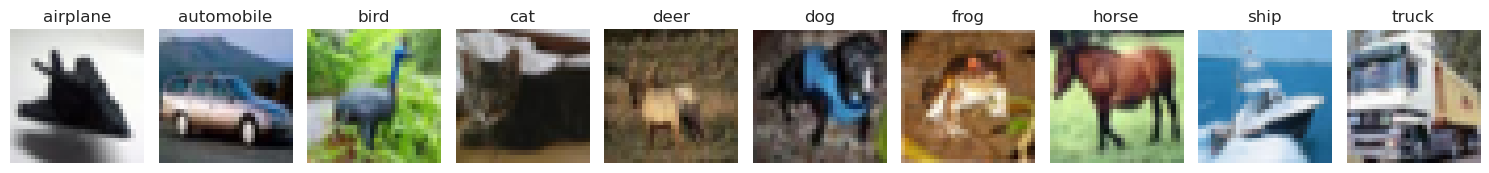

In [4]:
classes = train_dataset.classes

samples = {}
for img, label in train_dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == len(classes):
        break

# Plot the images.
fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))
for label, ax in enumerate(axs):
    img_np = samples[label].permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


## Helper Functions and General Layer Implementations

The next code cell includes various helper functions and layer implementations from the previous assignment. This set comprises:

- `softmax`
- `l2_regularization`
- `softmax_with_cross_entropy`
- `Param`
- `ReluLayer`
- `FullyConnectedLayer`
- `check_gradient`
- `check_layer_gradient`
- `check_layer_param_gradient`
- `check_model_gradient`

These utilities serve debugging and validation purposes and are not directly relevant to the core of this assignment. It is advisable to collapse this cell during code review.


In [5]:
def softmax(x):
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exps = np.exp(x_shifted)
    return exps / np.sum(exps, axis=1, keepdims=True)


def l2_regularization(W, reg_strength):
    loss = np.sum(np.square(W)) * reg_strength
    grad = 2 * reg_strength * W
    return loss, grad


def softmax_with_cross_entropy(predictions, target_index):
    batch_size = predictions.shape[0]
    probs = softmax(predictions)
    correct_probs = probs[np.arange(batch_size), target_index]
    loss = -np.sum(np.log(correct_probs)) / batch_size  # Average loss
    d_pred = probs.copy()
    d_pred[np.arange(batch_size), target_index] -= 1
    d_pred /= batch_size  # Normalize gradient
    return loss, d_pred


class Param:
    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)


class ReLULayer:
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = X > 0
        X = X * self.mask
        return X

    def backward(self, d_out):
        d_result = d_out * self.mask

        return d_result

    def params(self):
        return {}


class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * cp.random.randn(n_input, n_output))
        self.B = Param(0.001 * cp.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        X = cp.array(X)
        self.X = X

        return X @ self.W.value + self.B.value

    def backward(self, d_out):
        d_out = cp.array(d_out)

        d_input = d_out @ self.W.value.T

        d_W = self.X.T @ d_out
        self.W.grad += d_W

        d_B = np.sum(d_out, axis=0, keepdims=True)
        self.B.grad += d_B

        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}


class Model:
    def __init__(self, layers):
        """
        Initialize the model with a list of layers.
        """
        self.layers = layers

    def forward(self, x):
        """
        Perform a forward pass through all layers.
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        """
        Backpropagate the gradient through all layers.
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def compute_loss_and_grad(self, predictions, target_index):
        """
        Compute the softmax with cross entropy loss and return both the loss
        and the gradient.
        """
        loss, grad = softmax_with_cross_entropy(predictions, target_index)
        return loss, grad

    def params(self):
        """
        Collects parameters from all layers.
        Returns a dictionary mapping layer names to their parameters.
        """
        parameters = {}
        for idx, layer in enumerate(self.layers):
            for name, param in layer.params().items():
                parameters[f"layer{idx}_{name}"] = param
        return parameters

    def update_params(self, lr):
        """
        Updates all parameters.
        """
        for param in self.params().values():
            param.value -= lr * param.grad
            param.grad = np.zeros_like(param.grad)

    def train(self, lr, epochs, data_loader):
        """
        Trains the model.
        data_loader should yield batches as (x, y) where:
          - x is input with shape (batch_size, input_size)
          - y contains the target class indices for each sample.
        """
        loss_list = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            for x, y in data_loader:
                # Forward pass: compute predictions for the current batch.
                predictions = self.forward(x)

                # Compute loss and gradient at the output.
                loss, grad = self.compute_loss_and_grad(predictions, y)
                epoch_loss += loss

                # Backward pass: propagate gradients through the network.
                self.backward(grad)

                # Update all parameters using gradient descent.
                self.update_params(lr)

            avg_loss = epoch_loss / len(data_loader)
            loss_list.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        # Plot training loss.
        plt.plot(loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()


import numpy as np


def check_gradient(f, x, delta=1e-5, tol=1e-4):
    """
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula

    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Return:
      bool indicating whether gradients match or not
    """
    # assert isinstance(x, np.ndarray)
    # assert x.dtype == float

    x = np.array(x.get() if isinstance(x, cp.ndarray) else x, copy=True, order='C')
    x.setflags(write=True)  # Explicitly make writeable

    fx, analytic_grad = f(x)
    analytic_grad = analytic_grad.copy()

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]

        arg_array_minus = np.copy(x)
        arg_array_plus = np.copy(x)
        arg_array_minus[ix] -= delta
        arg_array_plus[ix] += delta

        fx_plus, _ = f(arg_array_plus)
        fx_minus, _ = f(arg_array_minus)

        numeric_grad_at_ix = (fx_plus - fx_minus) / (2 * delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (
                ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the input and output of a layer

    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Returns:
      bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol)


def check_layer_param_gradient(layer, x,
                               param_name,
                               delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the parameter of the layer

    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      param_name: name of the parameter (W, B)
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Returns:
      bool indicating whether gradients match or not
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = cp.asarray(w) if isinstance(layer, ConvolutionalLayerGPU) else w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = cp.asnumpy(param.grad) if isinstance(param.grad, cp.ndarray) else param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)


def check_model_gradient(model, X, y,
                         delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters

    Returns:
      bool indicating whether gradients match or not
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True

## Historical Perspective on Visual Processing and CNN Development

The design of Convolutional Neural Networks is rooted in early neuroscience research that explored how the visual cortex processes information. Hubel and Wiesel’s work in the 1960s was pivotal: through experiments with kittens, they demonstrated that during a critical developmental period, deprivation of visual input in one eye led to a marked reorganization of cortical cells. Their findings showed that neurons in the visual cortex become specialized for processing specific visual stimuli, forming the basis for later understanding of hierarchical feature extraction.

<img src="imgs/exp_setup.png" width="600px"> <img src="imgs/exp_res.png" width="240px">

This diagram illustrates the core principle behind Hubel and Wiesel’s experiments on orientation selectivity in the visual cortex. A cat is shown with an electrode placed in its brain’s visual area, and a bar of light is presented at various angles on a screen. On the right, the electrical responses recorded by the electrode demonstrate how specific cortical neurons respond most strongly to particular orientations of the bar. These findings revealed the nature of feature detection in the brain, particulary in this lab case represented as orientation-selective detectors, but potentially could capture more rich context and also include hierarchical nature of features extraction.

Hubel and Wiesel’s research not only provided a critical understanding of visual system development but also laid the groundwork for modern computer vision approaches, influencing the evolution of CNN architectures that power today's image recognition systems.

## CNN Idea

The idea of Convolutional Neural Networks is influenced and named after the mathematical operation Convolution, which map vector(in our case on techincal level the matrix might be reshaped into vector) into scalar using set of values that serve as weights for each item of input. Convolution operation might also be used for various tasks beyond Convolutional Neural Networks such as, signal smoothing in audio processing, edge detection in image processing, filtering in communication systems, and deblurring in computational photography. These diverse applications leverage the fundamental ability of convolution to extract, combine, or highlight specific features within data.

For image data, convolution is particularly advantageous because it exploits the spatial structure inherent in images. By applying a small filter across the entire image, the convolution operation is able to capture local patterns and textures regardless of their position, leading to translation invariance. This weight-sharing mechanism not only reduces the number of learnable parameters, enhancing computational efficiency, but also builds a hierarchy of features—from simple edges and textures to complex shapes and objects. These benefits make convolution an ideal tool for image recognition, classification, and other computer vision tasks.

<img src="imgs/cnn_arch.jpg" width="800px">

## CNN Architecture

This biological insight directly inspired the structure of CNNs. A typical CNN architecture consists of a series of convolutional layers that receptive fields in the visual cortex by detecting local features in the input image, often followed by pooling layers that reduce spatial dimensions and highlight dominant signals. The extracted feature maps are then flattened into a one-dimensional vector, which is passed through fully connected layers to perform classification. Activation functions, such as ReLU, are interspersed throughout these layers to introduce nonlinearity and enhance the network’s ability to model complex patterns.



## Convolutional Layer

The `ConvolutionalLayer` class implements a convolutional layer by directly applying the convolution operation on the input data. In the forward pass, it slides a filter over the input image, extracts a small patch at each spatial location, and reshapes that patch of shape `(batch_size, filter_size, filter_size, in_channels)` into a two-dimensional matrix with shape `(batch_size, filter_size * filter_size * in_channels)`. At the same time, the filter weights, stored in a four-dimensional tensor of shape `(filter_size, filter_size, in_channels, out_channels)`, are reshaped into a matrix of shape `(filter_size * filter_size * in_channels, out_channels)`. This reshape allows the convolution operation to be performed efficiently using matrix multiplication. In mathematical terms, if we denote the reshaped patch as $P \in \mathbb{R}^{N \times (k^2 C)}$ and the reshaped weights as $W \in \mathbb{R}^{(k^2 C) \times F}$, the convolution operation for a specific output position is computed as:

### Convolutional Layer GPU

I also want you to review the second notebook I have submitted, it dives into my research, implementation and evaluation of the Convolution algorithm designed for GPU computations.


In [6]:
class ConvolutionalLayer:
    def __init__(self, in_channels, out_channels,
                 filter_size, padding):
        self.filter_size = filter_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Param(
            np.random.randn(filter_size, filter_size, in_channels, out_channels) * np.sqrt(
                2.0 / (filter_size * filter_size * in_channels))
        )

        self.B = Param(np.zeros(out_channels))

        self.padding = padding

        self.last_X = None

    def forward(self, X):
        # get shape of the input tensor
        batch_size, in_channels, height, width = X.shape

        # compute shape of output tensor
        out_height = height - self.filter_size + 1 + 2 * self.padding
        out_width = width - self.filter_size + 1 + 2 * self.padding

        # pad the input tensor
        X = np.pad(X, ((0, 0), (0, 0), (self.padding,) * 2, (self.padding,) * 2))

        # save last input for backward pass
        self.last_X = X

        # create zeros tensor for result
        result = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # reshape weights to use matrix multiplication trick
        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size, self.out_channels)

        # iterate each pixel in output tensor
        for y in range(out_height):
            for x in range(out_width):
                # take the perception widow of the output pixel
                patch = X[:, :, y:y + self.filter_size, x:x + self.filter_size]

                # unwrap patch to use matrix multiplication trick
                patch_flat = patch.reshape(batch_size, self.in_channels * self.filter_size * self.filter_size)

                # convolution operation
                res = patch_flat @ weights

                # add bias to result
                res += self.B.value

                # add pixels to result tensor
                result[:, :, y, x] = res

        return result

    def backward(self, d_out):
        # get shape of last input passed to forward pass
        batch_size, in_channels, height, width = self.last_X.shape

        # get shape of the received gradient
        _, out_channels, out_height, out_width = d_out.shape

        # create d_input with proper shape
        d_X = np.zeros_like(self.last_X)

        # get and reshape weights to use in calculations
        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size, self.out_channels)

        for y in range(out_height):
            for x in range(out_width):
                # take the gradient patch (batch_size, out_channels)
                gradient_patch = d_out[:, :, y, x]

                # get and reshape input patch to (batch_size, self.in_channels*self.filter_size*self.filter_size)
                input_patch = self.last_X[:, :, y:y + self.filter_size, x:x + self.filter_size]
                input_patch_flat = input_patch.reshape(batch_size,
                                                       self.in_channels * self.filter_size * self.filter_size)

                # d_X to get gradient with respect to input -> d_out + weights

                d_input_flat = gradient_patch @ weights.T

                d_input_patch = d_input_flat.reshape(batch_size, in_channels, self.filter_size, self.filter_size)

                d_X[:, :, y:y + self.filter_size, x:x + self.filter_size] += d_input_patch

                # d_w gradient with respect to weights -> d_out + inputs
                d_flat_w = input_patch_flat.T @ gradient_patch

                d_w = d_flat_w.reshape(self.filter_size, self.filter_size, self.in_channels, self.out_channels)

                self.W.grad += d_w

                # d_b gradient with respect to bias term -> d_out

                d_b = np.sum(gradient_patch, axis=0)

                self.B.grad += d_b

        # return d_X without padding
        return d_X[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else d_X

    def params(self):
        return {'W': self.W, 'B': self.B}

In [7]:
def im2col_idx(x_shape, filter_size, stride):
    """
    Generate indices required for extracting image patches for convolution operation.

    Params:
        x_shape: Tuple representing the shape of input tensor (batch_size, height, width, channels)
        filter_size: Size of convolutional filter (assumed square)
        stride: Stride size for sliding the filter

    Returns:
        batch_indices: Indices corresponding to batch dimension
        y_indices: Indices for each patch along height dimension
        x_indices: Indices for each patch along width dimension
        channel_indices: Indices corresponding to channel dimension
    """
    batch_size, ch, h, w = x_shape

    # y_start for height patch starts, x_start for width patch starts
    y_start = np.arange(0, h - filter_size + 1, stride)
    x_start = np.arange(0, w - filter_size + 1, stride)

    # meshgrid(y_start, x_start) for in-kernel positions
    y_starts, x_starts = np.meshgrid(y_start, x_start, indexing='ij')  # [H_out, W_out]

    dy, dx = np.mgrid[0:filter_size, 0:filter_size]  # [filter_size, filter_size]

    y_indices = y_starts[:, :, None, None] + dy  # [H_out, W_out, k, k]
    x_indices = x_starts[:, :, None, None] + dx  # [H_out, W_out, k, k]

    # Add batch and channel dimensions
    batch_indices = np.arange(batch_size)[:, None, None, None, None, None]  # [N, 1, 1, 1, 1, 1]
    channel_indices = np.arange(ch)[None, None, None, :, None, None]  # [1, 1, 1, C, 1, 1]
    # the order plays crucial role in proper ordering when indexing and reshaping

    return batch_indices, y_indices, x_indices, channel_indices


def im2col_matrix(X, filter_size, stride):
    """
    Converts batched images into a matrix format suitable for efficient GPU-based convolution operations.

    Params:
        X: Input tensor of images with shape (batch_size, height, width, in_channels)
        filter_size: Size of convolutional filter (assumed square)
        stride: Stride size for sliding the convolutional filter

    Returns:
        A reshaped matrix suitable for convolution with shape:
        (batch_size * height_out * width_out, filter_size * filter_size * in_channels)
    """
    batch_size, ch, h, w = X.shape
    h_out = (h - filter_size) // stride + 1
    w_out = (w - filter_size) // stride + 1

    batch_indices, y_indices, x_indices, channel_indices = im2col_idx(X.shape, filter_size, stride)

    # Expand indices for broadcasting
    y_indices_exp = y_indices[np.newaxis, :, :, np.newaxis, :, :]  # [1, 1, H_out, W_out, k, k]
    x_indices_exp = x_indices[np.newaxis, :, :, np.newaxis, :, :]  # [1, 1, H_out, W_out, k, k]

    # Extract patches
    patches = X[
        batch_indices,  # [N, 1, 1, 1, 1, 1]
        channel_indices,  # [1, C, 1, 1, 1, 1]
        y_indices_exp,  # [1, 1, H_out, W_out, k, k]
        x_indices_exp  # [1, 1, H_out, W_out, k, k]
    ]  # [N, C, H_out, W_out, k, k]

    # Reshape to [N * H_out * W_out, k * k * C]
    return patches.reshape(batch_size * h_out * w_out, filter_size * filter_size * ch)


def col2im_backward(dx_patches, x_shape, filter_size, stride):
    batch_size, in_ch, h_in, w_in = x_shape

    # Initialize the result tensor to accumulate gradients
    result = np.zeros((batch_size, in_ch, h_in, w_in))

    # Retrieve indices used previously in im2col to map patches back to input positions
    batch_idx, y_idx, x_idx, channel_idx = im2col_idx(x_shape, filter_size, stride)

    y_idx = y_idx[np.newaxis, :, :, np.newaxis, :, :]
    x_idx = x_idx[np.newaxis, :, :, np.newaxis, :, :]

    # Expand indices dimensions for broadcasting compatibility
    batch_idx = batch_idx + np.zeros_like(y_idx) + np.zeros_like(channel_idx)
    channel_idx = channel_idx + np.zeros_like(y_idx) + np.zeros_like(batch_idx)
    y_idx = y_idx + np.zeros_like(channel_idx) + np.zeros_like(batch_idx)
    x_idx = x_idx + np.zeros_like(channel_idx) + np.zeros_like(batch_idx)

    # Flatten indices and gradients to enable accumulation
    batch_idx_flat = batch_idx.ravel()
    y_idx_flat = y_idx.ravel()
    x_idx_flat = x_idx.ravel()
    channel_idx_flat = channel_idx.ravel()
    dx_patches_flat = dx_patches.ravel()

    # Accumulate gradients from dx_patches back into original input tensor positions
    np.add.at(result, (batch_idx_flat, channel_idx_flat, y_idx_flat, x_idx_flat), dx_patches_flat)

    return result


class ConvolutionalLayerGPU:
    def __init__(self, in_channels, out_channels,
                 filter_size, padding):
        self.filter_size = filter_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Param(
            cp.random.randn(filter_size, filter_size, in_channels, out_channels) * np.sqrt(
                2.0 / (filter_size * filter_size * in_channels))
        )
        self.W.grad = cp.asarray(self.W.grad)

        self.B = Param(cp.zeros(out_channels))
        self.B.grad = cp.asarray(self.B.grad)

        self.padding = padding

        self.last_X = None
        self.last_X_shape = None
        # Store im2col matrix for backward pass
        self.im2col_input = None

    def forward(self, X):
        # get shape of the input tensor
        batch_size, in_channels, height, width = X.shape

        # compute shape of output tensor
        out_height = height - self.filter_size + 1 + 2 * self.padding
        out_width = width - self.filter_size + 1 + 2 * self.padding

        # pad the input tensor
        X = np.pad(X, ((0, 0), (0, 0), (self.padding,) * 2, (self.padding,) * 2))

        # save last input for backward pass
        self.last_X = X
        self.last_X_shape = X.shape

        self.im2col_input = im2col_matrix(X, self.filter_size,
                                          1)  # [batch_size * height_out * width_out, filter_size * filter_size * in_channels]

        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size,
                                       self.out_channels)  # [in_channels * filter_size * filter_size, out_channels}

        # im2col matrix to GPU
        self.im2col_input = cp.asarray(self.im2col_input)

        result = self.im2col_input @ weights + self.B.value  # [batch_size * height_out * width_out, out_channels]

        return cp.asnumpy(result.reshape(batch_size, self.out_channels, out_height, out_width))

    def backward(self, d_out):
        batch_size, in_channels, height, width = self.last_X.shape

        _, out_channels, out_height, out_width = d_out.shape

        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size,
                                       self.out_channels)  # [in_channels * filter_size * filter_size, out_channels]

        reshaped_d_out = d_out.reshape(batch_size * out_height * out_width,
                                       self.out_channels)  # [batch_size * out_height * out_width, out_channels]

        # reshaped d_out to GPU
        reshaped_d_out = cp.asarray(reshaped_d_out)

        # d_x -> d_out + weights
        backprop_matrix = reshaped_d_out @ weights.T  # [batch_size * out_height * out_width, filter_size * filter_size * in_channels]

        d_x = col2im_backward(cp.asnumpy(backprop_matrix), self.last_X_shape, self.filter_size, 1)

        # d_w -> d_out + inputs
        d_w = self.im2col_input.T @ reshaped_d_out  # [in_channels * filter_size * filter_size, out_channels]

        self.W.grad += d_w.reshape(self.W.value.shape)

        # d_b -> d_out

        d_b = np.sum(reshaped_d_out, axis=0)

        self.B.grad += d_b

        return d_x[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else d_x

    def params(self):
        return {'W': self.W, 'B': self.B}

## Max Pooling

MaxPooling is a downsampling operation reduces the spatial dimensions of an image while preserving important features, improving computational efficiency and reducing overfitting.

The MaxPooling layer works by:

- Dividing the input into non-overlapping patches.
- Selecting the maximum value from each patch.
- Producing a smaller output while retaining key information.

In [8]:
class MaxPoolingLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.X = None

    def forward(self, X):
        batch_size, channels, height, width = X.shape

        X = X.get() if isinstance(X, cp.ndarray) else X

        self.X = X

        # compute output tensor size
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        # init resulting tensor with proper shape
        result = np.zeros((batch_size, channels, out_height, out_width))

        for y in range(out_height):
            for x in range(out_width):
                start_y = y * self.stride
                start_x = x * self.stride

                # take input patch
                patch = X[:, :, start_y:start_y + self.pool_size, start_x:start_x + self.pool_size]

                # get maximum over axis (1,2) means for each batch(0) and chanel(3) get the maximum of matrix (pool_size, pool_size) that stores actual pixel values
                patch_max = np.max(patch, axis=(2, 3))

                # assign maximum over each batch and chanel to the point in result tensor
                result[:, :, y, x] = patch_max

        return result

    def backward(self, d_out):
        d_out = d_out.get() if isinstance(d_out, cp.ndarray) else d_out

        batch_size, channels, height, width = self.X.shape

        d_input = np.zeros_like(self.X)

        out_width = (width - self.pool_size) // self.stride + 1
        out_height = (height - self.pool_size) // self.stride + 1

        for y in range(out_height):
            for x in range(out_width):
                input_patch = self.X[:, :, y * self.stride:y * self.stride + self.pool_size,
                              x * self.stride:x * self.stride + self.pool_size]

                # Flatten each patch for max index computation
                input_patch_reshaped = input_patch.reshape(batch_size, channels, -1)

                # Find the index of the maximum value in each patch
                max_idx_local = np.argmax(input_patch_reshaped, axis=2)

                # Convert flat indices back to 2D indices
                row_idx_local, col_idx_local = np.unravel_index(max_idx_local, (self.pool_size, self.pool_size))

                # Convert local indices to global indices in the input tensor
                row_idx_global = row_idx_local + y * self.stride
                col_idx_global = col_idx_local + x * self.stride

                # Batch and channel indices for broadcasting
                batch_idx = np.arange(batch_size)[:, None]
                ch_idx = np.arange(channels)

                # Accumulate gradient values at the positions of the max values
                d_input[batch_idx, ch_idx, row_idx_global, col_idx_global] += d_out[:, :, y, x]

        return d_input

    def params(self):
        return {}

In [9]:
class Flattener:
    def __init__(self):
        self.X_shape = None

    def forward(self, X):
        batch_size, channels, height, width = X.shape

        self.X_shape = X.shape

        return X.reshape(batch_size, -1)

    def backward(self, d_out):
        return d_out.reshape(self.X_shape)

    def params(self):
        return {}


## Testing

After all the layers implemented we want to ensure all of them provides right results for both forward and backward pass. It is essential step when implementing such more complex logic from scratch, even small mismatch in dimension might lead to wrong computations and collapse future training process. For test we will assert shapes of result and use helper function to check analytical gradient using numerical gradient.

---
### Basic Convolution Shape Check

In [10]:
X = np.array([
    [  # Batch 0
        [[1.0, 2.0], [0.0, -1.0]]  # Channel 0 (NCHW format)
    ],
    [  # Batch 1
        [[0.0, 1.0], [-2.0, -1.0]]  # Channel 0
    ]
], dtype=np.float32)  # Shape: (2, 1, 2, 2)

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:", X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] + 1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])

# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

# And now multple input channels
X = np.array([
    [
        [[1.0, 0.0], [2.0, 1.0]],
        [[0.0, -1.0], [-1.0, -2.0]]
    ]
    ,
    [
        [[0.0, 1.0], [1.0, -1.0]],
        [[-2.0, 2.0], [-1.0, 0.0]]
    ]
])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

Shape of X: (2, 1, 2, 2)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


---
### Convolution GPU Shape Check

In [11]:
X = np.array([
    [  # Batch 0
        [[1.0, 2.0], [0.0, -1.0]]  # Channel 0 (NCHW format)
    ],
    [  # Batch 1
        [[0.0, 1.0], [-2.0, -1.0]]  # Channel 0
    ]
], dtype=np.float32)  # Shape: (2, 1, 2, 2)

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:", X.shape)

layer = ConvolutionalLayerGPU(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] + 1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])

# Now implement multiple output channels
layer = ConvolutionalLayerGPU(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

X = np.array([
    [  # Batch 0
        [  # Channel 0
            [1.0, 2.0],  # Height 0
            [0.0, -1.0]  # Height 1
        ],
        [  # Channel 1
            [0.0, 1.0],  # Height 0
            [-1.0, -2.0]  # Height 1
        ]
    ],
    [  # Batch 1
        [  # Channel 0
            [0.0, 1.0],  # Height 0
            [-2.0, -1.0]  # Height 1
        ],
        [  # Channel 2
            [1.0, -1.0],  # Height 0
            [2.0, 0.0]  # Height 1
        ]
    ]
])

print("Shape of X:", X.shape)
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

Shape of X: (2, 1, 2, 2)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


---
### Basic Convolution Gradient Check

In [12]:
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
# Note this kind of layer produces the same dimensions as input
assert d_input.shape == X.shape

# Actually test the backward pass
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=1)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=1)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=1)
assert check_layer_param_gradient(layer, X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


---
### Convolution GPU Gradient Check

In [13]:
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)

assert result.shape == X.shape, "Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_param_gradient(layer, X, 'B')


Gradient check passed!
Gradient check passed!
Gradient check passed!


---
### Max Pooling Forward and Backward test

In [14]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 2, 1, 1)

assert check_layer_gradient(pool, X)

Gradient check passed!


---
### Flattener Forward and Backward test

In [15]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2, 8)

assert check_layer_gradient(flattener, X)

Gradient check passed!


---
## Convolutions Benchmark

Next I want to ensure that my implementation of GPU algorithm actually provides better performance then the conventional CPU Convolution.

In [16]:
def benchmark_convolution(layer_class, device='cpu', iterations=1):
    # Input parameters
    batch_size = 256
    in_channels = 3
    out_channels = 64
    input_size = 32
    filter_size = 3
    padding = 1

    xp = cp if device == 'gpu' else np

    # Create data
    x = xp.random.randn(batch_size, in_channels, input_size, input_size).astype(cp.float32)

    # Initialize layer
    layer = layer_class(in_channels=in_channels,
                        out_channels=out_channels,
                        filter_size=filter_size,
                        padding=padding)

    # Timing
    forward_times = []
    backward_times = []

    for _ in range(iterations):
        # Forward pass
        start = time.perf_counter()
        out = layer.forward(x)
        if device == 'gpu':
            cp.cuda.Stream.null.synchronize()
        forward_times.append(time.perf_counter() - start)

        # Generate gradient
        grad = xp.ones_like(out)

        # Backward pass
        start = time.perf_counter()
        layer.backward(grad)
        if device == 'gpu':
            cp.cuda.Stream.null.synchronize()
        backward_times.append(time.perf_counter() - start)

    avg_forward = np.mean(forward_times)
    avg_backward = np.mean(backward_times)

    return avg_forward, avg_backward


# Run benchmarks
cpu_forward, cpu_backward = benchmark_convolution(ConvolutionalLayer, 'cpu')
gpu_forward, gpu_backward = benchmark_convolution(ConvolutionalLayerGPU, 'gpu')

print(f"CPU Convolution:")
print(
    f"Forward: {cpu_forward * 1000:.2f}ms | Backward: {cpu_backward * 1000:.2f}ms | Total: {(cpu_forward + cpu_backward) * 1000:.2f}ms")

print(f"\nGPU Convolution:")
print(
    f"Forward: {gpu_forward * 1000:.2f}ms | Backward: {gpu_backward * 1000:.2f}ms | Total: {(gpu_forward + gpu_backward) * 1000:.2f}ms")

# Calculate speedup
speedup_forward = cpu_forward / gpu_forward
speedup_backward = cpu_backward / gpu_backward
speedup_total = (cpu_forward + cpu_backward) / (gpu_forward + gpu_backward)

print(f"\nSpeedup:")
print(f"Forward: {speedup_forward:.1f}x | Backward: {speedup_backward:.1f}x | Total: {speedup_total:.1f}x")

CPU Convolution:
Forward: 303.17ms | Backward: 7561.55ms | Total: 7864.71ms

GPU Convolution:
Forward: 28.35ms | Backward: 220.50ms | Total: 248.85ms

Speedup:
Forward: 10.7x | Backward: 34.3x | Total: 31.6x


### Visualise Convolution

For the next step we will ensure the Convolution operation is working properly, by taking random image from dataset and applying conv with 3 input channels and 1 output. Here I use canny filter to capture the edges of the object over all 3 channels and put all data in one output channel. In the output image we should see more or less clear edges of an object.

In [16]:
def apply_conv(img_np, kernel):
    img_display = img_np.transpose(1, 2, 0)

    plt.imshow(img_display, cmap='viridis')
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    test_conv = ConvolutionalLayer(3, 1, 3, 1)

    test_conv.W.value = np.asarray(kernel)
    test_conv.B.value = np.asarray(np.zeros((1, 1)))

    input = img_np[None, :, :, :]

    output = test_conv.forward(np.asarray(input))

    plt.imshow(output[0, 0, :, :], cmap='gray')
    plt.title("After Convolution")
    plt.axis("off")
    plt.show()


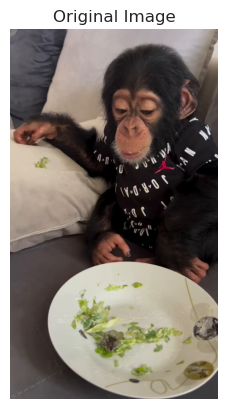

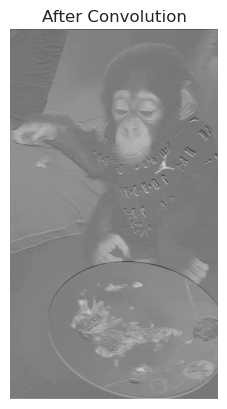

In [35]:
from PIL import Image

kernel = np.zeros((3, 3, 3, 1))

y_idx = np.array([1, 0, 2, 1])
x_idx = np.array([0, 1, 1, 2])
values = np.array([1, 1, -1, -1])

for in_ch in range(3):
    kernel[y_idx, x_idx, in_ch, 0] = values

img = Image.open("imgs/kiky.jpeg")
img_np = np.array(img).transpose(2, 0, 1) / 255

apply_conv(img_np, kernel)

# Testing Summary
At this moment the testing process is finishes, We implemented all the layers required to build convolutional neural network in both forward and backward passes. For the convolution Layer also implemented versions for CPU and GPU. During the testing, we checked forward and backward pass for each layer. For backward pass we used numerical method to estimate analytical gradient. Then the benchmark for performance showed that GPU computations are implemented correctly and algorithm time is increased dramatically. The last step was visual test with well known edge detection filter that showed that convolution operation is working.

---
# Training

In the training section I will setup the train for own implemented model to see if it is working properly, however I won't focus on evaluating results of its training and move directly to the PyTorch implementation. For the pytorch model I will interpret results and compare to ANN from previous assignment. At the end of the section I will also work with pre-trained convolutional backbone and will solve some bigger problem.

## Custom Model Training

In [52]:
class MomentumSGD:
    '''
    Implements Momentum SGD update
    '''

    def __init__(self, momentum=0.9):
        self.momentum = 0.9
        self.velocities = {}

    def update(self, w, d_w, learning_rate, param_name):
        '''
        Performs Momentum SGD update

        Arguments:
        w, np array - weights
        d_w, np array, same shape as w - gradient
        learning_rate, float - learning rate

        Returns:
        updated_weights, np array same shape as w
        '''

        if param_name not in self.velocities:
            self.velocities[param_name] = np.zeros_like(w)

        self.velocities[param_name] = self.momentum * self.velocities[param_name] - learning_rate * d_w

        return w + self.velocities[param_name]

def train_model(model, train_loader, test_loader, epochs, lr, optimizer=MomentumSGD(), save_path=None):
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    use_gpu = any(isinstance(layer, ConvolutionalLayerGPU) for layer in model.layers)
    xp = cp if use_gpu else np

    for epoch in range(epochs):
        # Training phase
        model.train_mode = True
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0
        batch_count = 0

        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 30)

        for x, y in train_loader:
            # Data conversion and transfer
            if use_gpu:
                x = cp.asarray(x.numpy(), dtype=cp.float32)
                y = cp.asarray(y.numpy())
            else:
                x = x.numpy().astype(np.float32)
                y = y.numpy()

            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Forward pass
            predictions = model.forward(x)
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Loss computation
            loss, grad = softmax_with_cross_entropy(predictions, y)
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Calculate training accuracy
            pred_classes = xp.argmax(predictions, axis=1)
            correct_train += xp.sum(pred_classes == y)
            total_train += len(y)

            # Backward pass
            model.backward(grad)
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Parameter update
            for param_name, param in model.params().items():
                param.value = optimizer.update(param.value, param.grad, lr, param_name)
                param.grad = xp.zeros_like(param.grad)

            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            epoch_loss += loss
            batch_count += 1

        # Calculate training metrics
        avg_train_loss = epoch_loss / batch_count
        train_accuracy = (correct_train / total_train) * 100
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        # Testing phase
        model.train_mode = False
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        test_batch_count = 0

        for x, y in test_loader:
            # Data conversion and transfer
            if use_gpu:
                x = cp.asarray(x.numpy(), dtype=cp.float32)
                y = cp.asarray(y.numpy())
            else:
                x = x.numpy().astype(np.float32)
                y = y.numpy()

            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Forward pass only (no backward pass during testing)
            predictions = model.forward(x)
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Calculate test loss
            batch_loss, _ = softmax_with_cross_entropy(predictions, y)
            test_loss += batch_loss

            # Calculate test accuracy
            pred_classes = xp.argmax(predictions, axis=1)
            correct_test += xp.sum(pred_classes == y)
            total_test += len(y)

            test_batch_count += 1

        # Calculate test metrics
        avg_test_loss = test_loss / test_batch_count
        test_accuracy = (correct_test / total_test) * 100
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_accuracy)

        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

    return history


model = Model([
    ConvolutionalLayerGPU(3, 32, 3, 1),  # Input: 3 channels, Output: 32 channels, 3x3 kernel, padding 1
    ReLULayer(),
    ConvolutionalLayerGPU(32, 64, 3, 1),  # 32 -> 64 channels, 3x3 kernel, padding 1
    ReLULayer(),
    MaxPoolingLayer(2, 2),  # 2x2 pooling with stride 2 -> output 64 * 16 * 16

    Flattener(),
    FullyConnectedLayer(64 * 16 * 16, 10),
])

In [ ]:
epochs = 5
learning_rate = 0.001

In [53]:
train_history = train_model(model, train_loader, test_loader, epochs, learning_rate)

Epoch 1/5
------------------------------
Train Loss: 2.5873 | Train Acc: 11.00%
Test Loss: 2.4435 | Test Acc: 10.49%

Epoch 2/5
------------------------------
Train Loss: 2.3672 | Train Acc: 12.60%
Test Loss: 2.3704 | Test Acc: 11.85%

Epoch 3/5
------------------------------
Train Loss: 2.0856 | Train Acc: 14.60%
Test Loss: 2.1114 | Test Acc: 12.15%

Epoch 4/5
------------------------------
Train Loss: 1.9006 | Train Acc: 15.40%
Test Loss: 1.9456 | Test Acc: 13.96%

Epoch 5/5
------------------------------
Train Loss: 1.7371 | Train Acc: 17.60%
Test Loss: 1.8138 | Test Acc: 15.03%



## PyTorch Implementation

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 512

# Create DataLoader with subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
from torch import optim


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, scheduler=None):
    """
    Enhanced training function that tracks and reports all key metrics

    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        criterion: Loss function
        optimizer: Optimization algorithm
        num_epochs: Number of training epochs
        scheduler: Optional learning rate scheduler

    Returns:
        dict: Dictionary containing training history with all metrics
    """
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * images.size(0)

        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                # Move data to GPU
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate test accuracy
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

                # Accumulate loss
                test_loss += loss.item() * images.size(0)

        # Calculate test metrics
        epoch_test_loss = test_loss / len(test_loader.dataset)
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(test_accuracy)

        # Scheduler step: for ReduceLROnPlateau, step using test loss; else, step normally.
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_test_loss)
            else:
                scheduler.step()

        # Print all metrics
        print(f"Epoch {epoch}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    # Return all metrics for further analysis
    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'test_loss': test_losses,
        'test_acc': test_accuracies
    }

In [29]:
from torch import nn

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # output: 256 x 4 x 4

    nn.Flatten(),
    nn.Linear(256 * 4 * 4, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

In [77]:
model = model.to(device)

In [78]:
num_epochs = 25

criterion = nn.CrossEntropyLoss()

opt = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.2)

In [79]:
history = train_model(model, train_loader, test_loader, criterion, opt, num_epochs, scheduler)

Epoch 1/25 - Train Loss: 1.9290, Train Acc: 27.23%, Test Loss: 1.5585, Test Acc: 41.57%
Epoch 2/25 - Train Loss: 1.3809, Train Acc: 49.34%, Test Loss: 1.2203, Test Acc: 55.54%
Epoch 3/25 - Train Loss: 1.0827, Train Acc: 61.01%, Test Loss: 1.0077, Test Acc: 64.04%
Epoch 4/25 - Train Loss: 0.8642, Train Acc: 69.14%, Test Loss: 0.8207, Test Acc: 71.61%
Epoch 5/25 - Train Loss: 0.7172, Train Acc: 74.55%, Test Loss: 0.7376, Test Acc: 73.92%
Epoch 6/25 - Train Loss: 0.5464, Train Acc: 80.61%, Test Loss: 0.6800, Test Acc: 76.90%
Epoch 7/25 - Train Loss: 0.4972, Train Acc: 82.33%, Test Loss: 0.6645, Test Acc: 77.22%
Epoch 8/25 - Train Loss: 0.4602, Train Acc: 83.90%, Test Loss: 0.6679, Test Acc: 77.75%
Epoch 9/25 - Train Loss: 0.4297, Train Acc: 84.95%, Test Loss: 0.6483, Test Acc: 78.27%
Epoch 10/25 - Train Loss: 0.3981, Train Acc: 86.12%, Test Loss: 0.6574, Test Acc: 78.66%
Epoch 11/25 - Train Loss: 0.3440, Train Acc: 88.33%, Test Loss: 0.6421, Test Acc: 79.22%
Epoch 12/25 - Train Loss: 0.33

In [83]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt


def eval_model(model, test_loader, classes=None, py_torch=False):
    """
    Evaluates a given model on a test set, printing key metrics and
    plotting a confusion matrix. You can pass an optional list of class
    names to label the axes of the confusion matrix.

    Parameters
    ----------
    model : nn.Module or similar
        The trained model to evaluate.
    test_loader : DataLoader
        A PyTorch DataLoader providing test batches (x, y).
    classes : list of str, optional
        List of class names for labeling the confusion matrix.
        If None, numeric labels are used.
    py_torch : bool, optional
        Indicates whether the model is a PyTorch model. If False,
        the model is assumed to be a NumPy-based model.
    Returns
    -------
    None
        Prints out accuracy, precision, recall, F1 score, classification
        report, and displays a confusion matrix heatmap.
    """
    if py_torch:
        model.eval()

    all_y_true = []
    all_y_pred = []

    # Iterate over the test set
    for x, y in test_loader:
        if py_torch:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

        # Forward pass
        y_hat = model.forward(x)

        if py_torch:
            # Move predictions and labels to CPU for metric computation
            preds = torch.argmax(y_hat, dim=1).detach().cpu().numpy()
            y = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        else:
            preds = np.argmax(y_hat, axis=1)
            # If y is a tensor, convert it to NumPy
            if isinstance(y, torch.Tensor):
                y = y.detach().cpu().numpy()

        # Now, y and preds should be NumPy arrays, so .astype works.
        all_y_true.extend(y.astype(int))
        all_y_pred.extend(preds.astype(int))

    # Convert to NumPy arrays
    # Convert to NumPy arrays by converting each element explicitly if it is a Cupy array.
    all_y_true = np.array([elem.get() if isinstance(elem, np.ndarray) else elem for elem in all_y_true])
    all_y_pred = np.array([elem.get() if isinstance(elem, np.ndarray) else elem for elem in all_y_pred])

    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    f1 = f1_score(all_y_true, all_y_pred, average='weighted', zero_division=0)

    # Print key metrics
    print("\n\033[1mEvaluation Metrics:\033[0m")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Classification report
    print("\n\033[1mClassification Report:\033[0m")
    print(classification_report(all_y_true, all_y_pred, zero_division=0))

    # Confusion matrix and heatmap
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=classes if classes else None,
        yticklabels=classes if classes else None
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

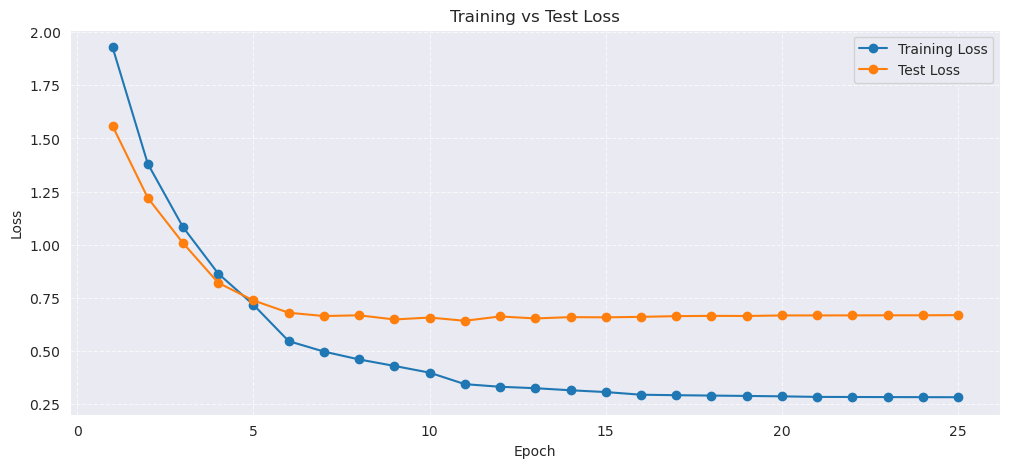

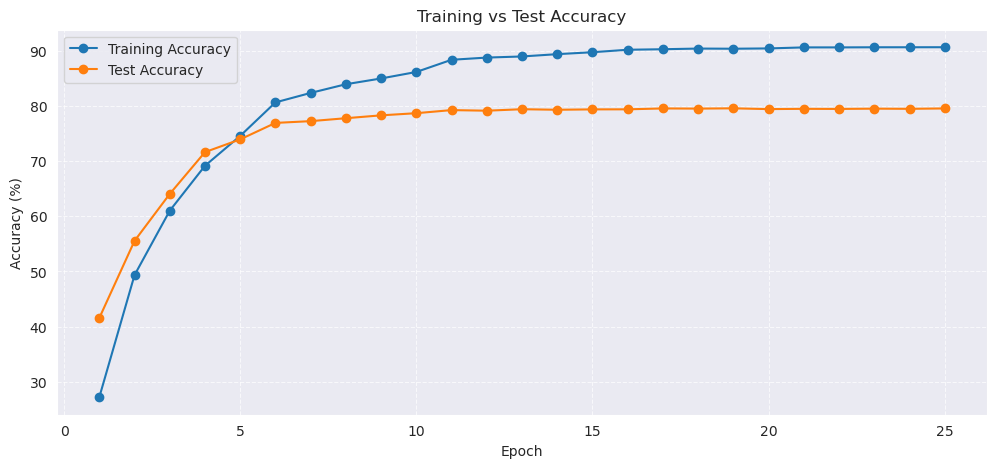


Evaluation Metrics:
Accuracy:  0.7952
Precision: 0.7945
Recall:    0.7952
F1 Score:  0.7947

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1000
           1       0.90      0.89      0.90      1000
           2       0.73      0.71      0.72      1000
           3       0.62      0.61      0.62      1000
           4       0.74      0.77      0.76      1000
           5       0.72      0.70      0.71      1000
           6       0.84      0.84      0.84      1000
           7       0.83      0.84      0.83      1000
           8       0.88      0.87      0.87      1000
           9       0.88      0.89      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.79      0.80      0.79     10000
weighted avg       0.79      0.80      0.79     10000



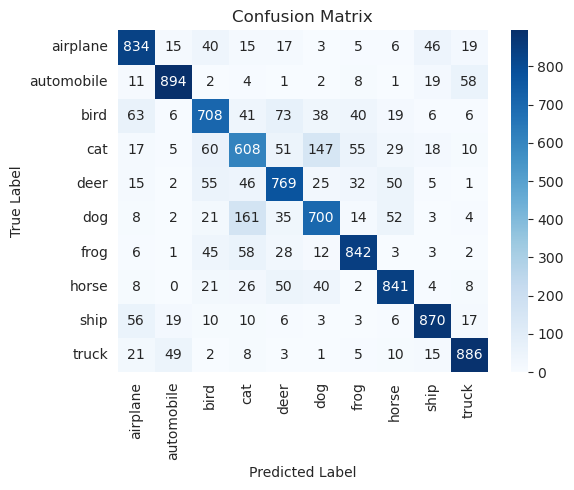

In [85]:
# Compare losses
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), history['train_loss'], marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), history['test_loss'], marker='o', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Compare accuracies
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), history['train_acc'], marker='o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history['test_acc'], marker='o', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

eval_model(model, test_loader, classes, py_torch=True)

## Results Evaluation

### Loss and Accuracy
The Loss history shows quite normal result for the Deep Learning Model. The growing gap between training and test loss suggests the model started to overfit the training data rather than learning generalizable patterns, however since the overfitting don't affect the Test loss it is okay to continue learning, in the case the loss started to decrease, it will be better to stop the train and adjust hyperparameters and regularizations.

The accuracy plots show the same motion, which is logical, since minimizing loss function implies the model predict better. The CNN did pretty well overall, with an 80% accuracy rate across all 10,000 test images.

### Confusion Matrix

Looking at the confusion matrix, we can see which classes the CNN handled well and where it struggled. It was very good at identifying automobiles (894 correct out of 1000), trucks (886/1000), ships (870/1000) and airplanes which are human made objects and horses (841/1000), frogs (842/1000) which have more unique features among animals in the dataset. The model had the most trouble with cats, correctly identifying only 608 out of 1000. It often confused cats with dogs (147 mistakes) and dogs with cats (161 mistakes). This makes sense since these animals share similar features, especially in such low resolution.


### Compare with ANN

The ANN from previous assignment, performed much worse with only 45.44% accuracy overall.

The huge performance gap between the CNN (80% accuracy) and ANN (45.44% accuracy) shows why CNNs are the go-to for image tasks. CNNs are designed to understand patterns in images by processing them in chunks and maintaining the spatial relationships between pixels. Regular neural networks treat images as flat lists of pixel values without understanding how they relate to each other.

While this CNN isn't perfect and shows some signs of overfitting, it clearly learned meaningful visual patterns. The mistakes it made were generally reasonable - mixing up visually similar categories. The ANN's poor performance highlights how important it is to use the right tool for the job when working with images.

In [26]:
from torch.utils.data import Dataset
from torch import nn
import os
from torchvision import models

---
# Transfer Learning with Convolutional Backbone

In this last section, I will implement image classification model, using transfer learning with pre-trained convolutional neural network (CNN) backbones. Transfer learning leverages the knowledge gained from training on large datasets to improve performance on new tasks, often with less data and training time.

The idea being this method is to extract what is called feature map from the last layer of the CNN model and then train classifier to adapt for own task. There are 2 approaches of training such model, the first option to freeze entire backbone weights and only train classifier head and second is to allow last layer of backbone to train, which is called fine-tuning.


## Dataset

For this task I want to use some real-world dataset, which focuses on niche problem, in my case it is *Wheat Plant Diseases* dataset from kaggle(https://www.kaggle.com/datasets/kushagra3204/wheat-plant-diseases).

This dataset is designed to empower researchers and developers in creating robust machine learning models for classifying various wheat plant diseases. It offers a collection of high-resolution images showcasing real-world wheat diseases without the use of artificial augmentation techniques.
Content

Number of Images: 14,155

Image Quality: High-resolution image

Disease Classes:
- Aphid [Pest]
- Mite [Pest]
- Stem Fly [Pest]
- Rusts
    - Black Rust / Stem Rust
    - Brown Rust / Leaf Rust
    - Yellow Rust / Stripe Rust
- Smut (Loose, Flag)
- Common Root Rot
- Helminthosporium Leaf Blight / Leaf Blight
- Wheat Blast
- Fusarium head blight / Scab
- Septoria Leaf Blotch
- Spot Blotch
- Tan Spot
- Powdery Mildew

Disease Cause and Monitoring Information

Wheat Disease Cause: Wheat plants can contract diseases from various sources, but some of the most common culprits fall into these categories:
- Fungi: These microscopic organisms are a leading cause of wheat diseases. Examples include Fusarium (responsible for head blight and scab), Septoria (causing leaf blotch), and various rust fungi like stem rust, stripe rust, and leaf rust.
- Bacteria: Bacterial diseases are less frequent but can still cause significant damage. Examples include bacterial streak and bunt.
- Viruses: Wheat streak mosaic virus and Wheat dwarf virus are examples of viral diseases that can infect wheat.
- Environmental Conditions: Stressful conditions like excessive moisture, drought, extreme temperatures, or lack of essential nutrients can weaken wheat plants, making them more susceptible to opportunistic pathogens.
- Disease Monitoring Using Images: This guide will provide valuable information on how to leverage visual inspection of wheat plants and the dataset images for disease identification. It will detail key visual characteristics (symptoms) to look for when diagnosing specific diseases in wheat.

### Step 1: Create Dataset Class

In [18]:
class WheatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initialize custom dataset.

        Args:
            root_dir (str): Directory with all the images organized by class folders
            transform (callable, optional): Optional transform to be applied to samples
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Create a list of (image_path, class_index) tuples
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                class_idx = self.class_to_idx[class_name]
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if os.path.isfile(img_path):
                        self.samples.append((img_path, class_idx))

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Return a sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to return

        Returns:
            tuple: (image, label) where label is the class index
        """
        img_path, label = self.samples[idx]

        # Load image using PIL
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

### Step 2: Create transforamtion with data Augmentation for Training

In [19]:
# For training data: include data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),          # Random crop with resizing to 224x224
    transforms.RandomHorizontalFlip(),          # Randomly flip images horizontally
    transforms.RandomRotation(10),              # Randomly rotate images by ±10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet statistics
                         std=[0.229, 0.224, 0.225])
])

# For testing data: only resize and normalize
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet statistics
                         std=[0.229, 0.224, 0.225])
])

### Step 3: Create Dataset and DataLoader Instances


In [20]:
# Define paths to training and testing data
train_dir = 'data/wheat/train'
test_dir = 'data/wheat/test'

# Create dataset instances
train_dataset = WheatDataset(root_dir=train_dir, transform=train_transform)
test_dataset = WheatDataset(root_dir=test_dir, transform=test_transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Class names: {train_dataset.classes}")

# Create DataLoader for training and testing
train_loader = DataLoader(
    train_dataset,
    batch_size=1024,           # Number of samples per batch
    shuffle=True,            # Shuffle the data at each epoch
    num_workers=0,           # Number of subprocesses for data loading (if not 0 issue with Trying to resize storage that is not resizable)
    pin_memory=True          # Pin memory for faster data transfer to GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1024,           # Typically use the same batch size for testing
    shuffle=False,           # No need to shuffle for testing data
    num_workers=0,           # Same number of workers
    pin_memory=True          # Same memory settings
)

Number of training samples: 13104
Number of test samples: 750
Class names: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']


### Step 4: Load Backbone model

In [21]:
model = models.resnet50(weights='IMAGENET1K_V2')

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Approach 1: Only Classification Head

I dont think this will work, because the dataset specification is a lot different from the original ResNet training. The model is trained to recognise pattern that helps to distinguish between the images within dataset it was trained on. This implies that for such specific dataset it might struggle to provide the feature map that is enough to clasify on our task.

In [22]:
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

In [23]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 15


In [27]:
in_features = model.fc.in_features
print(f"Backbone feature dimension: {in_features}")

# Replace the final fully connected layer
model.fc = nn.Linear(in_features, num_classes)

Backbone feature dimension: 2048


In [28]:
# Count parameters and verify only classifier is trainable
total_params = 0
trainable_params = 0
frozen_params = 0

for name, param in model.named_parameters():
    param_count = param.numel()
    total_params += param_count

    if param.requires_grad:
        trainable_params += param_count
        print(f"Trainable: {name}, Shape: {param.shape}, Parameters: {param_count:,}")
    else:
        frozen_params += param_count

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
print(f"Frozen parameters: {frozen_params:,} ({frozen_params/total_params:.2%})")

Trainable: fc.weight, Shape: torch.Size([15, 2048]), Parameters: 30,720
Trainable: fc.bias, Shape: torch.Size([15]), Parameters: 15

Total parameters: 23,538,767
Trainable parameters: 30,735 (0.13%)
Frozen parameters: 23,508,032 (99.87%)


In [29]:
model = model.to(device)

In [30]:
print(f"Model is on: {next(model.parameters()).device}")

Model is on: cuda:0


In [31]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (only updating parameters that require gradients)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [36]:
# Number of training epochs
num_epochs = 20

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    scheduler=scheduler
)

Epoch 1/20 - Train Loss: 2.3590, Train Acc: 33.60%, Test Loss: 2.3401, Test Acc: 30.00%
Epoch 2/20 - Train Loss: 1.8133, Train Acc: 53.91%, Test Loss: 2.0769, Test Acc: 41.60%
Epoch 3/20 - Train Loss: 1.5079, Train Acc: 60.53%, Test Loss: 1.8955, Test Acc: 45.20%
Epoch 4/20 - Train Loss: 1.3314, Train Acc: 63.02%, Test Loss: 1.7758, Test Acc: 47.87%
Epoch 5/20 - Train Loss: 1.2110, Train Acc: 65.95%, Test Loss: 1.6782, Test Acc: 51.20%
Epoch 6/20 - Train Loss: 1.1337, Train Acc: 67.16%, Test Loss: 1.6079, Test Acc: 53.07%
Epoch 7/20 - Train Loss: 1.0709, Train Acc: 69.02%, Test Loss: 1.5514, Test Acc: 55.07%
Epoch 8/20 - Train Loss: 1.0381, Train Acc: 69.99%, Test Loss: 1.5437, Test Acc: 55.33%
Epoch 9/20 - Train Loss: 1.0365, Train Acc: 70.32%, Test Loss: 1.5389, Test Acc: 56.00%
Epoch 10/20 - Train Loss: 1.0317, Train Acc: 69.75%, Test Loss: 1.5317, Test Acc: 56.00%
Epoch 11/20 - Train Loss: 1.0195, Train Acc: 70.34%, Test Loss: 1.5290, Test Acc: 55.87%


KeyboardInterrupt: 